In [7]:
# Importing common Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

**Exploratory data analysis**

In [12]:
# Load the data
data = pd.read_csv('train.csv')
data.head()

,category,sub_category,crimeaditionalinfo
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...


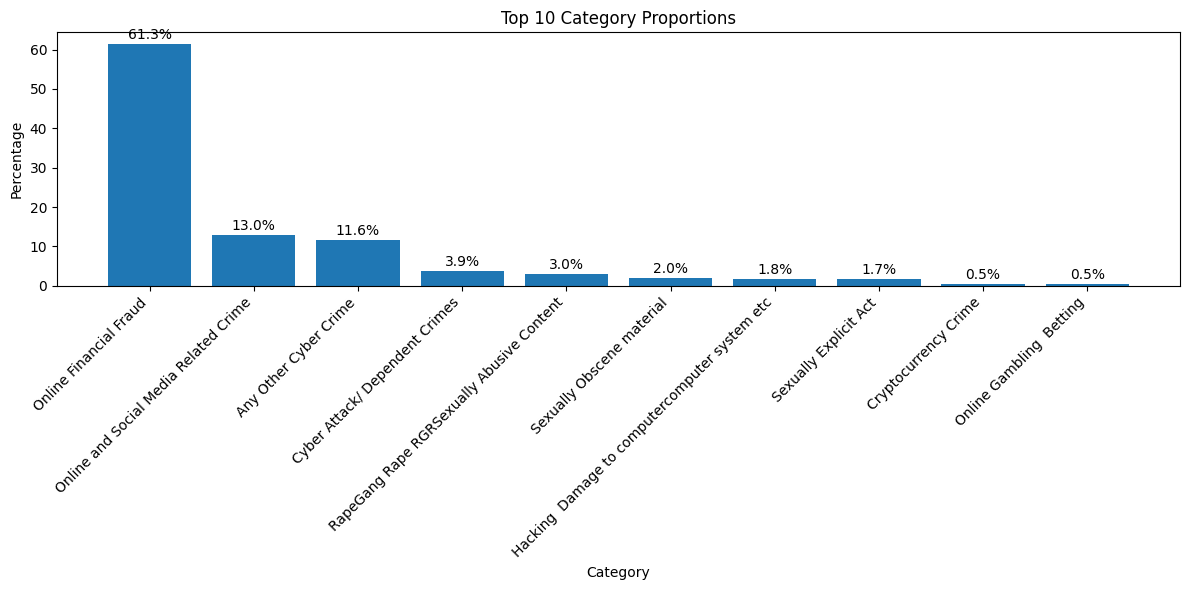

In [21]:
# Calculate category proportions for the top 10 categories
top_10_categories = data['category'].value_counts().nlargest(10).index
category_counts = data[data['category'].isin(top_10_categories)]['category'].value_counts()
category_percentages = (category_counts / len(data)) * 100

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(category_percentages.index, category_percentages.values)

# Add percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}%', ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Top 10 Category Proportions')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

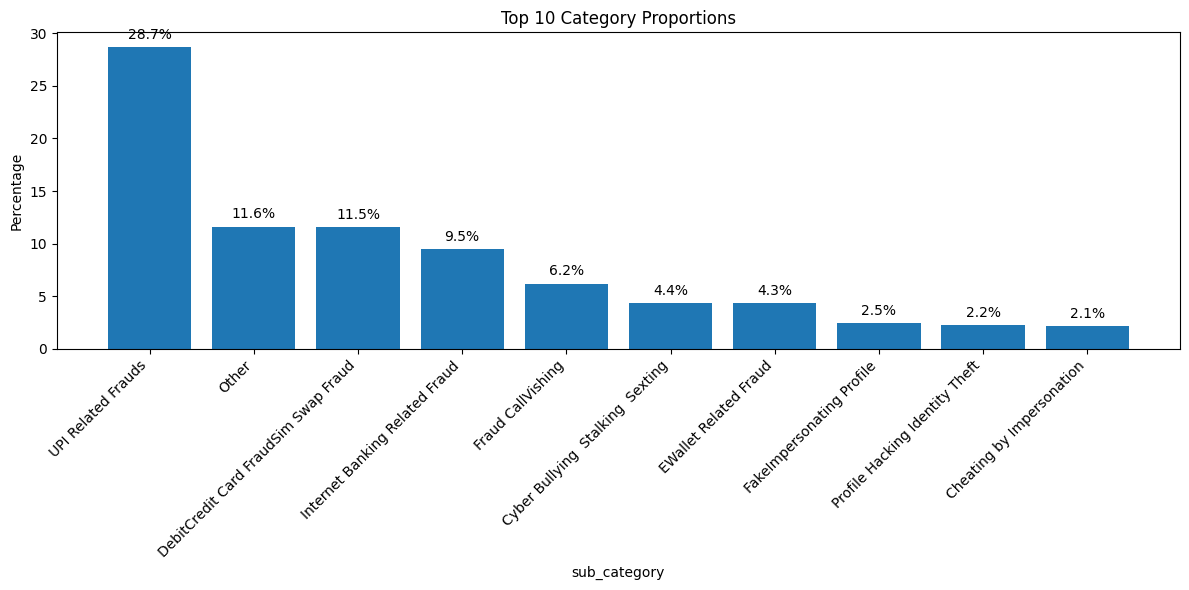

In [23]:
# Calculate sub_category proportions for the top 10 categories
top_10_categories = data['sub_category'].value_counts().nlargest(10).index
category_counts = data[data['sub_category'].isin(top_10_categories)]['sub_category'].value_counts()
category_percentages = (category_counts / len(data)) * 100

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(category_percentages.index, category_percentages.values)

# Add percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}%', ha='center', va='bottom')

plt.xlabel('sub_category')
plt.ylabel('Percentage')
plt.title('Top 10 Category Proportions')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')


def train_model(filename="in_train.csv", desired_sample_size=3000):
    """
    Trains a classification model on the given data.

    Args:
        filename (str): The path to the input CSV file.
        desired_sample_size (int): The desired number of samples for each sub_category after balancing.

    Returns:
        tuple: A tuple containing the trained model, the TF-IDF vectorizer,
               and the label encoders for category and sub_category.
    """

    # 1. Load Data
    data = pd.read_csv(filename)

    # 2. Text Preprocessing and Feature Extraction
    stop_words = set(stopwords.words('english'))
    data = data.dropna(subset=['crimeaditionalinfo'])
    data['crimeaditionalinfo'] = data['crimeaditionalinfo'].str.lower()
    data['crimeaditionalinfo'] = data['crimeaditionalinfo'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in stop_words])
    )


    # 3. Encoding Categorical Features
    label_encoder_category = LabelEncoder()
    data['category_encoded'] = label_encoder_category.fit_transform(data['category'].astype(str))

    label_encoder_subcategory = LabelEncoder()
    data['sub_category_encoded'] = label_encoder_subcategory.fit_transform(data['sub_category'].astype(str))

       # 4. Balance Sub_category
    balanced_data = pd.DataFrame()
    for sub_category in data['sub_category_encoded'].unique():
        sub_category_data = data[data['sub_category_encoded'] == sub_category]
        if len(sub_category_data) > desired_sample_size:
            sub_category_data = resample(sub_category_data, replace=False, n_samples=desired_sample_size, random_state=42)
        else:
            sub_category_data = resample(sub_category_data, replace=True, n_samples=desired_sample_size, random_state=42)
        balanced_data = pd.concat([balanced_data, sub_category_data])
    # Perform TF-IDF Vectorization after balancing the data
    vectorizer = TfidfVectorizer()
    x = vectorizer.fit_transform(balanced_data['crimeaditionalinfo']) # Use balanced_data here

    # 5. Data Splitting
    x_train, x_test, y_train_category, y_test_category, y_train_subcategory, y_test_subcategory = train_test_split(
        x, balanced_data['category_encoded'], balanced_data['sub_category_encoded'], test_size=0.2, random_state=42
    )

    # 6. Model Training (MultinomialNB)
    category_model = MultinomialNB()
    sub_category_model = MultinomialNB()

    category_model.fit(x_train, y_train_category)
    sub_category_model.fit(x_train, y_train_subcategory)

    # 7. Evaluate the Model
    y_pred_category = category_model.predict(x_test)
    y_pred_subcategory = sub_category_model.predict(x_test)

    print("Category Classification Report:")
    print(classification_report(y_test_category, y_pred_category))

    print("Sub-category Classification Report:")
    print(classification_report(y_test_subcategory, y_pred_subcategory))

    return category_model, sub_category_model, vectorizer, label_encoder_category, label_encoder_subcategory



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def train_and_evaluate_model(train_file="train.csv", test_file="test.csv", desired_sample_size=3000):
    """
    Trains a model on training data and evaluates it on test data,
    handling unseen labels in the test data.
    """

    # Train the model
    category_model, sub_category_model, vectorizer, label_encoder_category, label_encoder_subcategory = train_model(train_file, desired_sample_size)

    # Load and preprocess test data
    test_data = pd.read_csv(test_file)
    stop_words = set(stopwords.words('english'))
    test_data = test_data.dropna(subset=['crimeaditionalinfo'])
    test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].str.lower()
    test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in stop_words])
    )

    # Handle unseen labels in the test data
    # For categories:
    test_categories = test_data['category'].astype(str)
    unseen_categories = set(test_categories) - set(label_encoder_category.classes_)

    # If there are unseen categories, add them to the label encoder
    if unseen_categories:
        for category in unseen_categories:
            label_encoder_category.classes_ = np.append(label_encoder_category.classes_, category)

    # Now you can safely transform the test data
    test_data['category_encoded'] = label_encoder_category.transform(test_categories)
    # Repeat the same process for sub_categories:
    test_subcategories = test_data['sub_category'].astype(str)
    unseen_subcategories = set(test_subcategories) - set(label_encoder_subcategory.classes_)

    if unseen_subcategories:
        for subcategory in unseen_subcategories:
            label_encoder_subcategory.classes_ = np.append(label_encoder_subcategory.classes_, subcategory)

    test_data['sub_category_encoded'] = label_encoder_subcategory.transform(test_subcategories)

    x_test = vectorizer.transform(test_data['crimeaditionalinfo'])
    y_test_category = test_data['category_encoded']
    y_test_subcategory = test_data['sub_category_encoded']

    # Make predictions on the test data
    y_pred_category = category_model.predict(x_test)
    y_pred_subcategory = sub_category_model.predict(x_test)

    # Evaluate the model
    print("Category Accuracy on Test Data:", accuracy_score(y_test_category, y_pred_category))
    print("Sub-category Accuracy on Test Data:", accuracy_score(y_test_subcategory, y_pred_subcategory))

In [10]:
train_and_evaluate_model()

Category Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       584
           1       0.00      0.00      0.00        31
           2       0.97      0.27      0.42       625
           3       1.00      1.00      1.00      4103
           4       0.98      0.16      0.28       620
           5       0.90      0.61      0.72      2464
           6       0.98      0.07      0.14       587
           7       0.71      0.75      0.73      4201
           8       0.96      0.04      0.08       624
           9       0.58      0.95      0.72      6022
          10       0.99      0.49      0.66       609
          11       1.00      0.91      0.96       269
          12       1.00      1.00      1.00       549
          13       0.00      0.00      0.00       135
          14       0.00      0.00      0.00       177

    accuracy                           0.74     21600
   macro avg       0.67      0.42      0.45     